# Train and Test 1D Convolutional Neural Network

Author: Christopher Liu, 6/7/2021

In [6]:
import os, sys
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import sift_conv1dnet as sconv
from torch.utils.data import TensorDataset, DataLoader 
import matplotlib.pyplot as plt

## Load Data

In [7]:
# Time window
twin = 45

# Load fq data
npyd = 'npy'
eta = np.load(os.path.join(npyd,'fq_dart_eta.npy'))
t = np.load(os.path.join(npyd,'fq_dart_time.npy'))

# Load inversions
fq_wts = np.load(os.path.join(npyd,'fq_yong_inv_best.npy'))

# Split into train, validation,  and test sets
inddir = 'indices'

train_ind = np.loadtxt(os.path.join(inddir,'fq_dart_train_index.txt')).astype(int)
train_runs= np.loadtxt(os.path.join(inddir,'fq_dart_train_runs.txt')).astype(int)

test_ind = np.loadtxt(os.path.join(inddir,'fq_dart_test_index.txt')).astype(int)
test_runs= np.loadtxt(os.path.join(inddir,'fq_dart_test_runs.txt')).astype(int)

valid_ind = np.loadtxt(os.path.join(inddir,'fq_dart_valid_index.txt')).astype(int)
valid_runs= np.loadtxt(os.path.join(inddir,'fq_dart_valid_runs.txt')).astype(int)

eta_tr = eta[train_ind, :, :twin]
t_tr = t[train_ind, :, :twin]
target_tr = fq_wts[train_ind,:]

eta_ts = eta[test_ind, :, :twin]
t_ts = t[test_ind, :, :twin]
target_ts = fq_wts[test_ind,:]

eta_v = eta[valid_ind, :, :twin]
t_v = t[valid_ind, :, :twin]
target_v = fq_wts[valid_ind,:]

# Convert to tensors. Will need to redo if i want to keep track of run numbers...

batch = 20
shuf = False

train_x = torch.Tensor(eta_tr)
train_y = torch.Tensor(target_tr)

test_x = torch.Tensor(eta_ts)
test_y = torch.Tensor(target_ts)

valid_x = torch.Tensor(eta_v)
valid_y = torch.Tensor(target_v)

# Using the pytorch dataloader
train_dataset = TensorDataset(train_x,train_y)
test_dataset = TensorDataset(test_x,test_y)
valid_dataset = TensorDataset(valid_x,valid_y)

train_dataloader = DataLoader(train_dataset, batch_size = batch, shuffle = shuf, drop_last= True)
test_dataloader = DataLoader(test_dataset, batch_size = batch, shuffle = shuf, drop_last= True)
valid_dataloader = DataLoader(valid_dataset, batch_size = batch, shuffle = shuf, drop_last= True)

## Train

In [8]:
def valid(dataloader, model, loss_fn):
    size = len(dataloader) # number of batches
    valid_model = model.eval()
    valid_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = valid_model(X)
            
            valid_loss += loss_fn(pred, y).item()
    valid_loss /= size
    
    return valid_loss

In [9]:
# Set Device
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

# Specify model, loss function, and optimizer.
nsources = 31 # Number of unit sources used in inversion
model = sconv.Conv1DNN(3, nsources).to(device)

loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

Using cpu device


In [10]:
epochs = 300
nbatches = len(train_dataloader)
train_loss_array = np.zeros(epochs)
test_loss_array = np.zeros(epochs)
valid_loss_array = np.zeros(epochs)

for t in range(epochs):
    train_loss = 0.0
    
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_func(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # keep track of training loss
        train_loss += loss.item()
    
    # Calculating the batch-averaged loss
    avg_train_loss = train_loss/nbatches
    avg_valid_loss = valid(valid_dataloader, model, loss_func)
    avg_test_loss = valid(test_dataloader, model, loss_func)
    model.train(True) #Do i need this?
        
    # every 50 epochs, print test error. Adjust print frequency 
    # depending on epoch size
#     if (t+1) % 50 == 0:
#         print('Epoch: %s' % str(t+1))
#         print('------')
#         print(f"Avg Train loss: {avg_train_loss:>8f} \n")
#         print(f"Avg Validation loss: {avg_valid_loss:>8f} \n")
#         print(f"Avg Test loss: {avg_test_loss:>8f} \n")
    
    train_loss_array[t] = avg_train_loss
    valid_loss_array[t] = avg_valid_loss
    test_loss_array[t] = avg_test_loss

## Plot batch-averaged MSE versus epochs

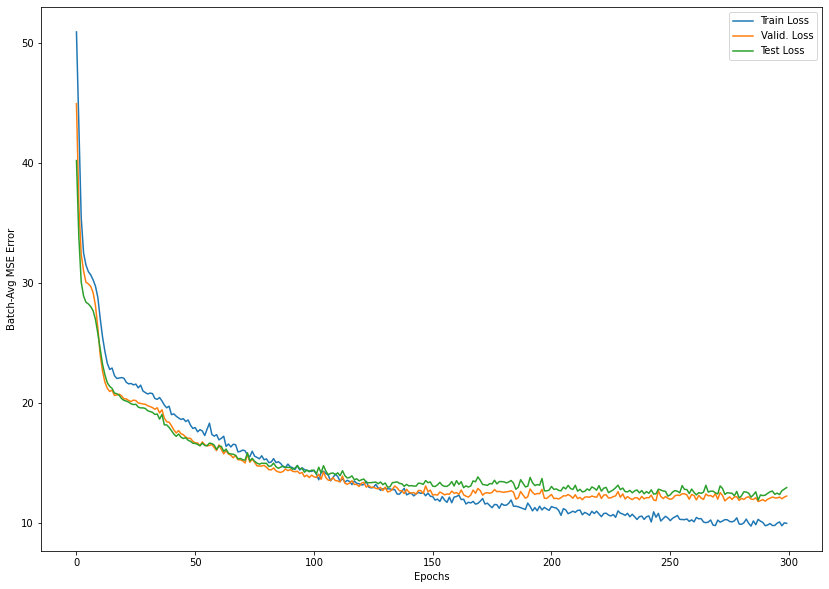

In [11]:
plt.figure(figsize=(14,10))
plt.plot(train_loss_array, label='Train Loss')
plt.plot(valid_loss_array, label='Valid. Loss')
plt.plot(test_loss_array, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Batch-Avg MSE Error')
plt.legend()
#plt.savefig('error_3000_epoch.png')

## Output results for plotting

Use model to predict test, validiation, and training data.

In [12]:
model.eval() # mportant to disable dropout layers
with torch.no_grad():
    pred_test = model(test_x)
    pred_train = model(train_x)
    pred_valid = model(valid_x)
    print(loss_func(pred_test,test_y).item())

12.915111541748047


#### Output results as .npy

In [13]:
np.save(os.path.join(npyd,'fq_conv1d_wts_test_300.npy'), pred_test.detach().numpy())
np.save(os.path.join(npyd,'fq_conv1d_wts_train_300.npy'), pred_train.detach().numpy())
np.save(os.path.join(npyd,'fq_conv1d_wts_valid_300.npy'), pred_valid.detach().numpy())

#### Or alternatively output as a .csv file

In [ ]:
np.savetxt(os.path.join(npyd,'fq_conv1d_wts_test_300.csv'),pred_test.detach().numpy(), delimiter=',')
np.savetxt(os.path.join(npyd,'fq_conv1d_wts_train_300.csv'),pred_train.detach().numpy(), delimiter=',')
np.savetxt(os.path.join(npyd,'fq_conv1d_wts_valid_300.csv'),pred_valid.detach().numpy(), delimiter=',')

# Output the model
See https://pytorch.org/tutorials/beginner/basics/saveloadrun_tutorial.html for more details

In [ ]:
save_model = model(pre_trained=True)
torch.save(save_model.state_dict(), 'model_weights.pth')